<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Coffee & Tea Subreddits Analysis - NLP

Note: This is part 2 of the code notebook covering the following:-
1. [Library Imports & Functions Creation](#1.-Library-Imports-&-Functions-Creation)
2. [Preparation for Modeling](#2.-Preparation-for-Modeling)
3. [Baseline Model: Naives Bayes](#3.-Baseline-Model:-Naives-Bayes)
4. [Rerunning Baseline Models: NB, KNN, Random Forest & Log Reg](#4.-Rerunning-Baseline-Models:-NB,-KNN,-Random-Forest-&-Log-Reg)
5. [HyperPara Models: NB, KNN, Random Forest & Log Reg](#5.-HyperPara-Models:-NB,-KNN,-Random-Forest-&-Log-Reg)
6. [Summary of Notebook 2](#6.-Summary-of-Notebook-2)

## 1. Library Imports & Functions Creation

In [1]:
import pandas as pd
import re   
import matplotlib.pyplot as plt
import nltk
import numpy as np
import warnings
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter

In [2]:
def stemming(x):
    p_stemmer = PorterStemmer()
    x = p_stemmer.stem(x)
    return x

In [3]:
def obviouswords_cleaner(x):
    x = x.split()
    for i in obvious_words:
        while i in x:
            x.remove(i)
    x = ' '.join(x)
    return x

In [4]:
def print_score(model, X_train, y_train, X_test, y_test):
    print(f'{model} train score: {model.score(X_train, y_train):.3f}')
    print(f'{model} train score: {model.score(X_test, y_test):.3f}')

In [5]:
def gridsearch_score(model, X_train, y_train, X_test, y_test):
    print(f'Train score: {model.best_score_:.3f}')
    print(f'Test score: {model.score(X_test, y_test):.3f}')
    print(f'Best parameters: {model.best_params_}')

## 2. Preparation for Modeling

We shall prepare the datasets for modelling.

The process is as follows:
1. Import both datasets from notebook 1;
2. Delete unnecessary columns;
3. Combine both datasets;
4. Impute 1 and 0 for Coffee and Tea under subreddit column; and 
5. Apply stemming before modelling.

Note: The column 'text_cleaned', which will be used for modelling, has already been cleaned under notebook 1 for EDA. However, further cleaning is still required. The column was previously lemmatize in order to pick out common words. Stemming is still required in order to streamline the number of words generated from vectorization. 

In [6]:
# Importing datasets
coffee_df = pd.read_csv('coffee_df_cleaned.csv')
tea_df = pd.read_csv('tea_df_cleaned.csv')

In [7]:
# Drop unnecessary columns
coffee_df.drop(columns = ['author', 'date_posted', 'text'], inplace = True)
tea_df.drop(columns = ['author', 'date_posted', 'text'], inplace = True)

In [8]:
# Combining both datasets
coffee_tea_df = pd.concat([coffee_df,tea_df])

In [9]:
# Impute 1, 0 for Coffee and Tea respectively
coffee_tea_df = coffee_tea_df.replace({"subreddit" : {"Coffee" : 1, "tea" : 0}})

In [10]:
# Checking for missing values after streamlining data
pd.DataFrame(coffee_tea_df.isna().sum())
pd.DataFrame(coffee_tea_df.isna().sum()).reset_index()
missing_df = pd.DataFrame(tea_df.isna().sum()).reset_index()
missing_df.columns = ['col', 'num_nulls'] 
missing_df['%nulls'] = missing_df['num_nulls']*100/len(tea_df)
missing_df = missing_df[missing_df['num_nulls']>0].sort_values(by=["%nulls"], ascending=False)
print(f'There are {len(missing_df)} columns with missing values.')
print('')
missing_df

There are 1 columns with missing values.



,col,num_nulls,%nulls
1,text_cleaned,7,0.058577


In [11]:
coffee_tea_df.dropna(inplace=True)
coffee_tea_df.reset_index(drop=True, inplace=True)

In [12]:
# Applying stemming
coffee_tea_df['text_cleaned'] = coffee_tea_df['text_cleaned'].apply(stemming)

In [13]:
# Viewing dataset before modeling
coffee_tea_df

,subreddit,text_cleaned
0,1,coffee reduces cardiovascular disease large po...
1,1,europeans get coffee stareuro
2,1,dark stormy coffee learning 12oz black coffee ...
3,1,learn roast coffee beans learning particular b...
4,1,roast
...,...,...
25376,0,favorite tea brands moved new city sadly go te...
25377,0,new ring mad hatter cosplay
25378,0,yummy tea break
25379,0,teacups youd love post without worry look love...


## 3. Baseline Model: Naives Bayes

In [14]:
# Vectorization
tfid = TfidfVectorizer(stop_words='english')
coffee_tea_tfid = tfid.fit_transform(coffee_tea_df['text_cleaned'])

In [15]:
# Making into a dataframe
warnings.simplefilter(action='ignore', category=FutureWarning)
coffee_tea_tfid = pd.DataFrame.sparse.from_spmatrix(coffee_tea_tfid, columns = tfid.get_feature_names())

In [16]:
X = coffee_tea_tfid
y = coffee_tea_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

In [17]:
nb = MultinomialNB()
naives = nb.fit(X_train, y_train)

In [18]:
print_score(naives, X_train, y_train, X_test, y_test)

MultinomialNB() train score: 0.962
MultinomialNB() train score: 0.931


### Evaluation of Baseline Model

1. With a train score of 0.962 and test score of 0.931, the naives bayes model is clearly performing well even though there is the issue of overfitting (approx 0.03). 
2. For classification model, a test score of 0.931 will mean that the model has a 93.1% accurancy in predicting if a post belongs to the coffee/tea subreddit. 
3. Given the high base model score, I will proceed to examine the obvious words based on the base model contributing to the high score. The rationale is that such words might not always be present in a post and removing them can provide more room for enchancement through selection of other models and applying hyperparameter tuning.
4. To remove obvious words, I will list out the 30 best performing words for the prediction of coffee and tea subreddit respectively. Any words that intuitively lean towards either category shall be removed.

In [19]:
# Listing the 30 best performing words for coffee
out_arr = pd.Series(naives.feature_log_prob_[0], index = coffee_tea_tfid.columns).to_frame()
out_arr.sort_values(by=0, ascending=False)
out_arr.reset_index(inplace=True)
out_arr = out_arr.rename(columns={'index': 'Features', 0: 'Prob'})
out_arr['Prob'] = np.exp(out_arr['Prob'])
out_arr.sort_values(by='Prob', ascending=False).head(30)

,Features,Prob
33341,tea,0.015159
33543,teas,0.002554
16141,green,0.002352
23390,new,0.001904
33519,teapot,0.001810
5817,black,0.001730
21598,matcha,0.001611
24359,oolong,0.001564
20195,leaf,0.001539
20835,loose,0.001424


In [20]:
# Listing the 30 best performing words for tea
out_arr = pd.Series(naives.feature_log_prob_[1], index = coffee_tea_tfid.columns).to_frame()
out_arr.sort_values(by=0, ascending=False)
out_arr.reset_index(inplace=True)
out_arr = out_arr.rename(columns={'index': 'Features', 0: 'Prob'})
out_arr['Prob'] = np.exp(out_arr['Prob'])
out_arr.sort_values(by='Prob', ascending=False).head(30)

,Features,Prob
8683,coffee,0.010750
16205,grinder,0.002871
13132,espresso,0.002774
21139,machine,0.002396
5262,beans,0.002366
6479,brew,0.002079
16196,grind,0.001956
8680,coffe,0.001873
36613,water,0.001871
10294,cup,0.001850


Of the lists, 16 words have been earmarked to be removed.

In [21]:
# Removal of obvious words
obvious_words = ["tea", "teas", "teapot", "matcha", "oolong", "leaf", "leaves", "coffee", "grinder", "espresso", "beans", "brew", "grind", "coffe", "roast", "aeropress"] 
coffee_tea_df['text_cleaned'] = coffee_tea_df['text_cleaned'].apply(obviouswords_cleaner)

## 4. Rerunning Baseline Models: NB, KNN, Random Forest & Log Reg

Given the removal of the obvious words, I shall rerun the baseline naive bayes model together with other base models such as k-nearest neighbor, random forest and logistic regression.

In [22]:
# Applying tfid vectorization again given that obvious words have been removed
tfid = TfidfVectorizer(stop_words='english')
coffee_tea_tfid = tfid.fit_transform(coffee_tea_df['text_cleaned'])

In [23]:
warnings.simplefilter(action='ignore', category=FutureWarning)
coffee_tea_tfid = pd.DataFrame.sparse.from_spmatrix(coffee_tea_tfid, columns = tfid.get_feature_names())

In [24]:
X = coffee_tea_tfid
y = coffee_tea_df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

### Base: Naives Bayes

In [25]:
nb = MultinomialNB()
nb = nb.fit(X_train, y_train)

In [26]:
print_score(nb, X_train, y_train, X_test, y_test)

MultinomialNB() train score: 0.912
MultinomialNB() train score: 0.855


### Base: K-Nearest Neighbor

In [27]:
knn = KNeighborsClassifier()
knn = knn.fit(X_train, y_train)

In [28]:
print_score(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier() train score: 0.728
KNeighborsClassifier() train score: 0.539


### Base: Random Forest

In [29]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
print_score(rf, X_train, y_train, X_test, y_test)

RandomForestClassifier() train score: 0.996
RandomForestClassifier() train score: 0.843


### Base: Logistic Regression

In [31]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [32]:
print_score(logreg, X_train, y_train, X_test, y_test)

LogisticRegression() train score: 0.936
LogisticRegression() train score: 0.867


### Evaluation of Base Models

| Index | Model Name | Base Training Accuracy Score | Base Test Accuracy Score| 
|:---:|:---:|:---:|:---:|
| 1 | Naives Bayes | 0.912 |  0.855  | 
| 2 | K-Nearest Neighbor | 0.728 | 0.539  | 
| 3 | Random Forest | 0.996 | 0.846 | 
| 4 | Logistic Regression | 0.936 | 0.867 |

1. After removing the obvious words from the dataset, the performance of modelling clearly performs worst. For instance, the train score of naives baynes dropped from 0.931 to 0.855. It is safe to resume that this would have been true for the other models should they undergo the same modelling with the obvious words.
2. Given the low test score of 0.539, k-nearest neighbor is clearly the worse model. The rest of the models are comparable in accuracy based on test score. Nevertheless, all models have clear sign of overfitting with the random forest being the most obvious due to its almost perfect training score.
3. Hyperparameter tuning will be applied for all the models in order to increase the accuracy of the test score and to lower the degree of overfitting.

## 5. HyperPara Models: NB, KNN, Random Forest & Log Reg

We shall proceed to apply hyperparameter tuning in order to improve the results of the base models.

### HyperPara: Naives Bayes

In [33]:
nb_params = {
    'alpha': [0.11, 0.12],
    'fit_prior':[True, False]}

In [34]:
nb_gridsearch = GridSearchCV(MultinomialNB(),
                              nb_params, 
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1 
                             )

In [35]:
# This code will take awhile to run
nb_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [36]:
gridsearch_score(nb_gridsearch, X_train, y_train, X_test, y_test)

Train score: 0.866
Test score: 0.861
Best parameters: {'alpha': 0.11, 'fit_prior': True}


### HyperPara: K-Nearest Neighbor

In [37]:
knn_params = {
    'n_neighbors': range(3, 8, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']}

In [38]:
knn_gridsearch = GridSearchCV(KNeighborsClassifier(), # estimator: What is the model we want to fit?
                              knn_params, # param_grid: What is the dictionary of hyperparameters?
                              cv=5, # What number of folds in CV will we use?
                              verbose=1, # Display limited output post grid searching
                              n_jobs=-1 # Use all CPU cores on your computer to speed up the fit
                             )

In [39]:
# This code will take awhile to run
knn_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [40]:
gridsearch_score(knn_gridsearch, X_train, y_train, X_test, y_test)

Train score: 0.591
Test score: 0.621
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


### HyperPara: Random Forest

In [41]:
rf_params = {
    'n_estimators': [120, 130],
    'criterion':['entropy', 'log_loss'],
    'max_depth':[110, 115],
    'min_samples_split': [30, 40]}

In [42]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                              rf_params, 
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1 
                             )

In [43]:
# This code will take awhile to run
rf_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [44]:
gridsearch_score(rf_gridsearch, X_train, y_train, X_test, y_test)

Train score: 0.836
Test score: 0.832
Best parameters: {'criterion': 'entropy', 'max_depth': 110, 'min_samples_split': 30, 'n_estimators': 130}


### HyperPara: Logistic Regression

In [45]:
lr_params = {
    'penalty': ['l1', 'l2'],
    'C':[3.3, 3.4, 3.5],
    'class_weight':[None, 'balanced'],
    'solver': ['saga']}

In [46]:
lr_gridsearch = GridSearchCV(LogisticRegression(),
                              lr_params, 
                              cv=5, 
                              verbose=1, 
                              n_jobs=-1 
                             )

In [47]:
# This code will take awhile to run
lr_gridsearch.fit(X_train, y_train);

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [48]:
gridsearch_score(lr_gridsearch, X_train, y_train, X_test, y_test)

Train score: 0.869
Test score: 0.871
Best parameters: {'C': 3.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


### Evaluation of HyperPara Models

| Index | Model Name | Base Training Accuracy Score | Base Test Accuracy Score| HyperPara Training Accuracy Score | HyperPara Test Accuracy Score| Best Parameters |
|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| 1 | Naives Bayes | 0.912 |  0.855  | 0.866 | 0.861 | <ul><li>alpha: 0.11</li><li>fit_prior: True</li></ul> |
| 2 | K-Nearest Neighbor | 0.728 | 0.539  | 0.591 | 0.621 | <ul><li>n_neighbors: 3</li><li>metric: euclidean</li><li>weights: distance</li></ul> |
| 3 | Random Forest | 0.996 | 0.846 | 0.836 | 0.833 | <ul><li>criterion: entropy</li><li>max_depth: 110</li><li>min_samples_split: 30</li><li>n_estimators: 125</li></ul> |
| 4 | Logistic Regression | 0.936 | 0.867 | 0.869 | 0.871 | <ul><li>C: 3.4</li><li>class_weight: None</li><li>penalty: l2</li><li>solver: saga</li></ul> |

1. Most models, apart from random forest, showed improvement on the accurancy based on test score. 
2. Despite the improvement, k-nearest neighbor is still the worst performing model.
3. All models were able to minimise the issue of overfitting through hyperparameter tuning by achieving a training accuracy score that is closer to the test accuracy score. 
4. With a test accuracy score of 0.871, logistic regression is clearly the best model. Furthermore, its training accuracy score differs from its test accuracy score by just 0.002. 
5. I shall provide further visualisations below for the logistic regression model.

### Receiver Operating Characteristic (ROC) Graph

<Figure size 1152x576 with 0 Axes>

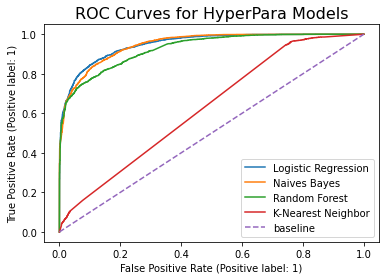

In [49]:
# Visualization of ROC curves for the hyperparameter models
fig = plt.figure(figsize=(16,8))
fig = plot_roc_curve(lr_gridsearch, X_test, y_test, label="Logistic Regression")
plot_roc_curve(nb_gridsearch, X_test, y_test, ax = fig.ax_, label="Naives Bayes")
plot_roc_curve(rf_gridsearch, X_test, y_test, ax = fig.ax_, label="Random Forest")
plot_roc_curve(knn_gridsearch, X_test, y_test, ax = fig.ax_, label="K-Nearest Neighbor")
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--') # to simulate random guess 
plt.legend()
plt.title("ROC Curves for HyperPara Models", size = 16)
plt.show;

### Confusion Matrix of Best Model

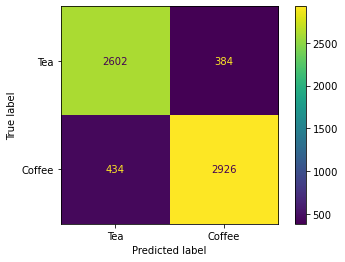

In [50]:
preds = lr_gridsearch.predict(X_test)
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tea', 'Coffee'])
disp.plot();

In [51]:
print(f'Accurancy score: {accuracy_score(y_test, preds):.3f}')
print(f'Recall score: {recall_score(y_test, preds):.3f}')

Accurancy score: 0.871
Recall score: 0.871


### Observation
1. The ROC graph confirms that the logistic regression is the best model with a curve that is furthest away from the baseline as compared to the other models.
2. The confusion matrix provides the visual on how the accuracy of the model is being calculated. Of interest to the project is only the accuracy score. Nevertheless, the matrix also helps us to see that the model is able to do a comparable job in classifying Coffee and Tea posts correctly with a score of 0.871 (recall score) and 0.872 (specificity score) respectively for each category. 

## 6. Summary of Notebook 2

| Model Name | Base Training Accuracy Score | Base Test Accuracy Score| HyperPara Training Accuracy Score | HyperPara Test Accuracy Score| Best Parameters |
|:---:|:---:|:---:|:---:|:---:|:---|
| Logistic Regression | 0.936 | 0.867 | 0.869 | 0.871 | <ul><li>C: 3.4</li><li>class_weight: None</li><li>penalty: l2</li><li>solver: saga</li></ul> |

Below is a summary of the main findings covered in this notebook :-

**1. Baseline Models**. 
   - Naives Bayes model was used as a base line model achieving a train score of 0.962 and test score of 0.931, which refers to the accurancy in prediction.
   - In order to make the classification task more realistic, obvious words are removed based on the top 30 best performing words in predicting coffee and tea posts respectively.
   - A further three models (K-Nearest Neighbor, Random Forest & Logistic Regression) were introduced as base models. As a reference point, the training and test scores of the Naives Bayes model decreased to 0.912 and 0.855 respectively.
   - K-Nearest Neighbor is the worse performing model, while the remaining models are comparable in their test accuracy score. 
   - All models have evidence of overfitting with Random Forest being the most obvious with a near perfect training accuracy score.  

**2. HyperParameter Models.**
   - Most models, apart from Random Forest, showed improvement on test accuracy score after hyperparamter tuning.
   - All models were able to minimise the impact of overfitting by achieving a training accuracy score that is closer to the test accuracy score.
   - K-Nearest Neighbor is still the worse performing model, while Logistic Regression is the best performing model (with the results indicated above).
   - Logistic Regression is able to acheive the best test accurancy score with the training accuracy differing by just 0.02.
   - Logistic Regression is able to do a comparable job in classifying Coffee and Tea posts correctly with a score of 0.871 (recall score) and 0.872 (specificity score) respectively for each category.